## ALE plots

In [1]:
import sys
sys.path

['c:\\D_Drive\\Indra\\github_projects\\explainability\\PyALE-master\\decoding',
 'c:\\Users\\iammo\\anaconda3\\envs\\demo01\\python311.zip',
 'c:\\Users\\iammo\\anaconda3\\envs\\demo01\\DLLs',
 'c:\\Users\\iammo\\anaconda3\\envs\\demo01\\Lib',
 'c:\\Users\\iammo\\anaconda3\\envs\\demo01',
 '',
 'c:\\Users\\iammo\\anaconda3\\envs\\demo01\\Lib\\site-packages',
 'c:\\Users\\iammo\\anaconda3\\envs\\demo01\\Lib\\site-packages\\win32',
 'c:\\Users\\iammo\\anaconda3\\envs\\demo01\\Lib\\site-packages\\win32\\lib',
 'c:\\Users\\iammo\\anaconda3\\envs\\demo01\\Lib\\site-packages\\Pythonwin']

In [2]:
alepath="C:\D_Drive\Indra\github_projects\explainability\PyALE-master"
sys.path.insert(0,alepath)
sys.path

['C:\\D_Drive\\Indra\\github_projects\\explainability\\PyALE-master',
 'c:\\D_Drive\\Indra\\github_projects\\explainability\\PyALE-master\\decoding',
 'c:\\Users\\iammo\\anaconda3\\envs\\demo01\\python311.zip',
 'c:\\Users\\iammo\\anaconda3\\envs\\demo01\\DLLs',
 'c:\\Users\\iammo\\anaconda3\\envs\\demo01\\Lib',
 'c:\\Users\\iammo\\anaconda3\\envs\\demo01',
 '',
 'c:\\Users\\iammo\\anaconda3\\envs\\demo01\\Lib\\site-packages',
 'c:\\Users\\iammo\\anaconda3\\envs\\demo01\\Lib\\site-packages\\win32',
 'c:\\Users\\iammo\\anaconda3\\envs\\demo01\\Lib\\site-packages\\win32\\lib',
 'c:\\Users\\iammo\\anaconda3\\envs\\demo01\\Lib\\site-packages\\Pythonwin']

In [3]:
from PyALE import ale, ALE_1D_IS, ALE_1D, ALE_2D, lib

In [4]:
ALE_1D_IS.fn_check()

2024-04-29 18:22:11.330 | INFO     | PyALE._src.ALE_1D_IS:fn_check:18 - In the fn_check method
2024-04-29 18:22:11.332 | DEBUG    | PyALE._src.ALE_1D_IS:fn_check:20 - A debug message.
2024-04-29 18:22:11.332 | INFO     | PyALE._src.ALE_1D_IS:fn_check:21 - An info message.
2024-04-29 18:22:11.334 | SUCCESS  | PyALE._src.ALE_1D_IS:fn_check:22 - A success message.
2024-04-29 18:22:11.335 | WARNING  | PyALE._src.ALE_1D_IS:fn_check:23 - A warning message.
2024-04-29 18:22:11.335 | ERROR    | PyALE._src.ALE_1D_IS:fn_check:24 - An error message.
2024-04-29 18:22:11.339 | CRITICAL | PyALE._src.ALE_1D_IS:fn_check:25 - A critical message.


# PyALE: Usage examples

In [5]:
import pandas as pd
pd.set_option("display.max_columns",None)
pd.set_option("display.max_colwidth",None)
import random
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder

## Prepare Data

In [6]:
# get the raw diamond data (from R's ggplot2)
# dat_diamonds = pd.read_csv(
#     "https://raw.githubusercontent.com/tidyverse/ggplot2/master/data-raw/diamonds.csv"
# )
dat_diamonds = pd.read_csv(".\Input_Data\diamonds.csv")
dat_diamonds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [7]:
X_raw = dat_diamonds.loc[:, ~dat_diamonds.columns.str.contains("price")].copy()
y = dat_diamonds["price"].copy()

In [8]:
X = X_raw.copy()
# convert the three text columns to ordered categoricals
X["cut"] = X["cut"].astype(
    pd.api.types.CategoricalDtype(
        categories=["Fair", "Good", "Very Good", "Premium", "Ideal"], ordered=True
    )
)
X["clarity"] = X["clarity"].astype(
    pd.api.types.CategoricalDtype(
        categories=["I1", "SI2", "SI1", "VS2", "VS1", "VVS2", "VVS1", "IF"],
        ordered=True,
    )
)

In [9]:
# use the codes of each categorical as a numeric encoding for the feature
X["cut_code"] = X["cut"].cat.codes
X["clarity_code"] = X["clarity"].cat.codes

In [10]:
# fit a one-hot-encoder before the function
# it is important to use a one-hot-encoder, that is fitted with all possible
# categories in the feature.
one_hot_encoder = OneHotEncoder().fit(X[["color"]])

def onehot_encode(feat, ohe=one_hot_encoder):
    col_names = ohe.categories_[0]
    feat_coded = pd.DataFrame(ohe.transform(feat).toarray())
    feat_coded.columns = col_names
    return feat_coded

In [11]:
coded_feature = onehot_encode(X[["color"]])
X = pd.concat([X, coded_feature], axis=1)

In [12]:
X.head()

,carat,cut,color,clarity,depth,table,x,y,z,cut_code,clarity_code,D,E,F,G,H,I,J
0,0.23,Ideal,E,SI2,61.5,55.0,3.95,3.98,2.43,4,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.21,Premium,E,SI1,59.8,61.0,3.89,3.84,2.31,3,2,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.23,Good,E,VS1,56.9,65.0,4.05,4.07,2.31,1,4,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.29,Premium,I,VS2,62.4,58.0,4.20,4.23,2.63,3,3,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.31,Good,J,SI2,63.3,58.0,4.34,4.35,2.75,1,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [13]:
features = ["carat", "cut_code", "clarity_code", "depth", "table", "x", "y", "z"]
features = features + coded_feature.columns.to_list()

In [14]:
X[features].head()

,carat,cut_code,clarity_code,depth,table,x,y,z,D,E,F,G,H,I,J
0,0.23,4,1,61.5,55.0,3.95,3.98,2.43,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.21,3,2,59.8,61.0,3.89,3.84,2.31,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.23,1,4,56.9,65.0,4.05,4.07,2.31,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.29,3,3,62.4,58.0,4.20,4.23,2.63,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.31,1,1,63.3,58.0,4.34,4.35,2.75,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Fit the model

In [15]:
model = RandomForestRegressor(random_state=1345)
model.fit(X[features], y)

RandomForestRegressor(random_state=1345)

### Discrete feature

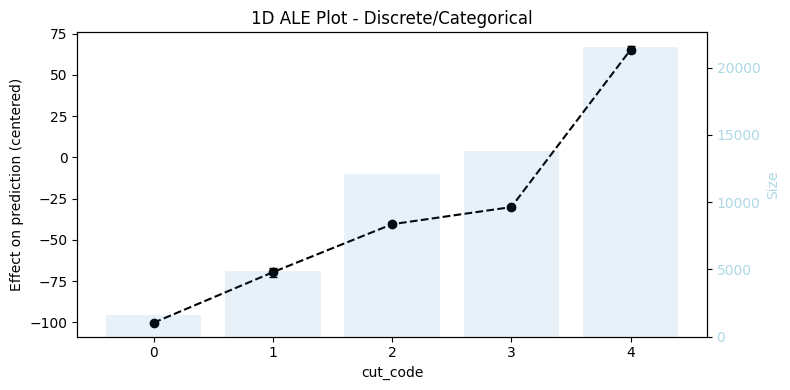

In [16]:
## 1D - discrete
ale_eff = ale(X=X[features], model=model, feature=["cut_code"])

In [17]:
X["cut_code"].value_counts()

cut_code
4    21551
3    13791
2    12082
1     4906
0     1610
Name: count, dtype: int64

In [18]:
res_df_is = ALE_1D_IS.aleplot_1D_discrete(X=X[features], model=model, feature='cut_code', include_CI=True, C=0.95, verbose=True)
res_df_is

2024-04-29 18:23:07.795 | INFO     | PyALE._src.ALE_1D_IS:aleplot_1D_discrete:198 - Starting of aleplot_1D_discrete
2024-04-29 18:23:07.797 | WARNING  | PyALE._src.ALE_1D_IS:aleplot_1D_discrete:199 - Start: Data types check of the function
2024-04-29 18:23:07.797 | WARNING  | PyALE._src.ALE_1D_IS:aleplot_1D_discrete:206 - End: Data types check of the function
2024-04-29 18:23:07.797 | DEBUG    | PyALE._src.ALE_1D_IS:aleplot_1D_discrete:209 - type(groups):<class 'numpy.ndarray'>
2024-04-29 18:23:07.807 | DEBUG    | PyALE._src.ALE_1D_IS:aleplot_1D_discrete:210 - Count of unique values: 5
2024-04-29 18:23:07.807 | DEBUG    | PyALE._src.ALE_1D_IS:aleplot_1D_discrete:212 - len(groups):5, Unique values of groups:[0 1 2 3 4]
2024-04-29 18:23:07.807 | DEBUG    | PyALE._src.ALE_1D_IS:aleplot_1D_discrete:215 - len(groups_codes):5, Unique values of groups_codes:{0: 0, 1: 1, 2: 2, 3: 3, 4: 4}
2024-04-29 18:23:07.807 | DEBUG    | PyALE._src.ALE_1D_IS:aleplot_1D_discrete:217 - type(feature_codes):<c

,local_mean_effects,Accumulated_local_mean_effects,size,Weight,proportional_weight,weighted_mean_of_accumulated_local_mean_effects,Weighted_mean_centered_ALE,cut_code,plus_n_neg_count,plus_count_min_to_max_minus_1_category,neg_count_min_plus_1_to_max_category,size_original,size_original_shift(1),consecutive_sizes_sum,Actual_Weight,Used_Weight_for_eff,Actual_proportional_weight,Actual_weighted_mean_of_accumulated_local_mean_effects,Actual_Weighted_mean_centered_ALE,eff,CI_estimate,lowerCI_95%_local_mean_effects,upperCI_95%_local_mean_effects,lowerCI_95%_Accumulated_local_mean_effects,upperCI_95%_Accumulated_local_mean_effects,lowerCI_95%_Weighted_mean_centered_ALE,upperCI_95%_Weighted_mean_centered_ALE,lowerCI_95%_Actual_Weighted_mean_centered_ALE,upperCI_95%_Actual_Weighted_mean_centered_ALE,lowerCI_95%,upperCI_95%
cut_code,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.000000,1610,1610,0.029848,100.172437,-100.172437,NaN,NaN,NaN,NaN,1610,NaN,NaN,0.0,1610,0.000000,104.742951,-104.742951,-100.172437,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,30.621169,30.621169,4906,4906,0.090953,100.172437,-69.551269,1.0,6516.0,1610.0,4906.0,4906,1610.0,6516.0,6516.0,4906,0.076913,104.742951,-74.121782,-69.551269,2.630188,27.990981,33.251357,27.990981,33.251357,-72.181457,-66.921081,-76.751970,-71.491594,-72.181457,-66.921081
2,29.086962,59.708130,12082,12082,0.223990,100.172437,-40.464307,2.0,16988.0,4906.0,12082.0,12082,4906.0,16988.0,16988.0,12082,0.200522,104.742951,-45.034821,-40.464307,1.269816,27.817145,30.356778,58.438314,60.977947,-41.734123,-39.194491,-46.304637,-43.765004,-41.734123,-39.194491
3,10.378303,70.086433,13791,13791,0.255673,100.172437,-30.086004,3.0,25873.0,12082.0,13791.0,13791,12082.0,25873.0,25873.0,13791,0.305398,104.742951,-34.656518,-30.086004,1.043824,9.334478,11.422127,69.042609,71.130257,-31.129829,-29.042180,-35.700342,-33.612694,-31.129829,-29.042180
4,95.340609,165.427042,21551,21551,0.399537,100.172437,65.254605,4.0,35342.0,13791.0,21551.0,21551,13791.0,35342.0,35342.0,21551,0.417167,104.742951,60.684091,65.254605,2.175793,93.164816,97.516403,163.251249,167.602835,63.078812,67.430398,58.508298,62.859884,63.078812,67.430398


In [19]:
res_df = ALE_1D.aleplot_1D_discrete(X=X[features], model=model, feature='cut_code', include_CI=True, C=0.95)
res_df

,eff,size,lowerCI_95%,upperCI_95%
cut_code,,,,
0,-100.172437,1610,NaN,NaN
1,-69.551269,4906,-72.181457,-66.921081
2,-40.464307,12082,-41.734123,-39.194491
3,-30.086004,13791,-31.129829,-29.042180
4,65.254605,21551,63.078812,67.430398


(<Figure size 800x400 with 2 Axes>,
 <Axes: xlabel='cut_code', ylabel='Effect on prediction (centered)'>,
 <Axes: title={'center': '1D ALE Plot - Discrete/Categorical'}, ylabel='Size'>)

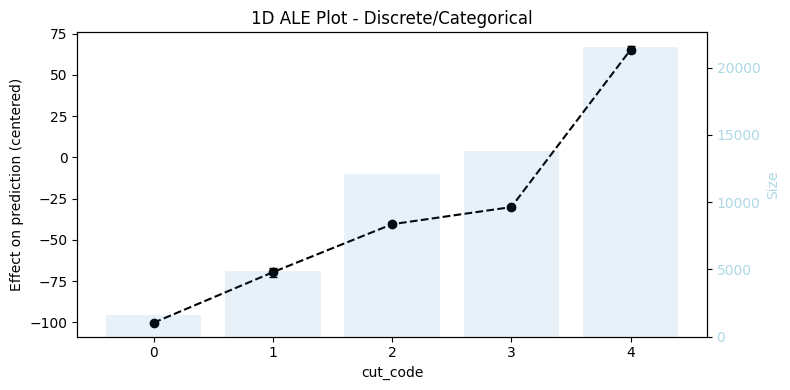

In [20]:
ALE_1D.plot_1D_discrete_eff(res_df, X, fig=None, ax=None)

(<Figure size 800x400 with 2 Axes>,
 <Axes: xlabel='cut_code', ylabel='Effect on prediction (centered)'>,
 <Axes: title={'center': '1D ALE Plot - Discrete/Categorical'}, ylabel='Size'>)

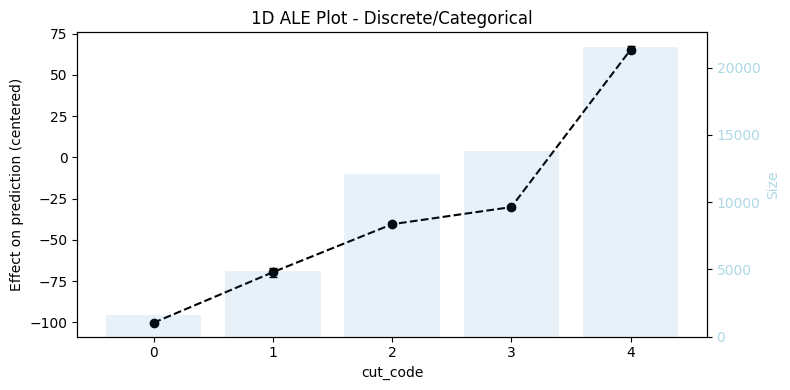

In [21]:
ALE_1D_IS.plot_1D_discrete_eff(res_df_is.loc[:,["eff", "size", "lowerCI_95%", "upperCI_95%"]], X, fig=None, ax=None, verbose=False)

2024-04-29 18:23:15.823 | INFO     | PyALE._src.ALE_1D_IS:plot_1D_discrete_eff:681 - Starting of plot_1D_discrete_eff
2024-04-29 18:23:15.828 | DEBUG    | PyALE._src.ALE_1D_IS:plot_1D_discrete_eff:682 - res_df.shape:(5, 4), res_df.head():                 eff   size  lowerCI_95%  upperCI_95%
cut_code                                             
0        -100.172437   1610          NaN          NaN
1         -69.551269   4906   -72.181457   -66.921081
2         -40.464307  12082   -41.734123   -39.194491
3         -30.086004  13791   -31.129829   -29.042180
4          65.254605  21551    63.078812    67.430398
2024-04-29 18:23:15.832 | DEBUG    | PyALE._src.ALE_1D_IS:plot_1D_discrete_eff:683 - X.shape:(53940, 18), X.head():   carat      cut color clarity  depth  table     x     y     z  cut_code  \
0   0.23    Ideal     E     SI2   61.5   55.0  3.95  3.98  2.43         4   
1   0.21  Premium     E     SI1   59.8   61.0  3.89  3.84  2.31         3   
2   0.23     Good     E     VS1   56.9

(<Figure size 800x400 with 2 Axes>,
 <Axes: xlabel='cut_code', ylabel='Effect on prediction (centered)'>,
 <Axes: title={'center': '1D ALE Plot - Discrete/Categorical'}, ylabel='Size'>)

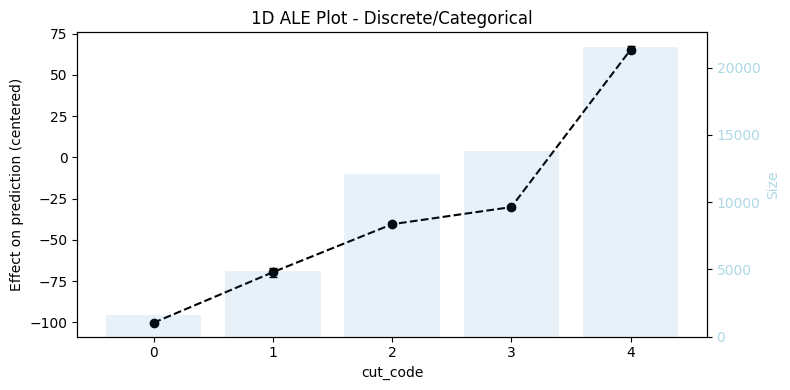

In [22]:
ALE_1D_IS.plot_1D_discrete_eff(res_df_is.loc[:,["eff", "size", "lowerCI_95%", "upperCI_95%"]], X, fig=None, ax=None, verbose=True)

2024-04-29 18:23:16.276 | INFO     | PyALE._src.ALE_1D_IS:plot_1D_discrete_eff2:738 - Starting of plot_1D_discrete_eff2
2024-04-29 18:23:16.283 | DEBUG    | PyALE._src.ALE_1D_IS:plot_1D_discrete_eff2:739 - res_df.shape:(5, 4), res_df.head():                 eff   size  lowerCI_95%  upperCI_95%
cut_code                                             
0        -100.172437   1610          NaN          NaN
1         -69.551269   4906   -72.181457   -66.921081
2         -40.464307  12082   -41.734123   -39.194491
3         -30.086004  13791   -31.129829   -29.042180
4          65.254605  21551    63.078812    67.430398
2024-04-29 18:23:16.293 | DEBUG    | PyALE._src.ALE_1D_IS:plot_1D_discrete_eff2:740 - X.shape:(53940, 18), X.head():   carat      cut color clarity  depth  table     x     y     z  cut_code  \
0   0.23    Ideal     E     SI2   61.5   55.0  3.95  3.98  2.43         4   
1   0.21  Premium     E     SI1   59.8   61.0  3.89  3.84  2.31         3   
2   0.23     Good     E     VS1   

(<Figure size 800x400 with 2 Axes>,
 <Axes: xlabel='cut_code', ylabel='Effect on prediction (centered)'>,
 <Axes: title={'center': '1D ALE Plot - Discrete/Categorical'}, ylabel='Size'>)

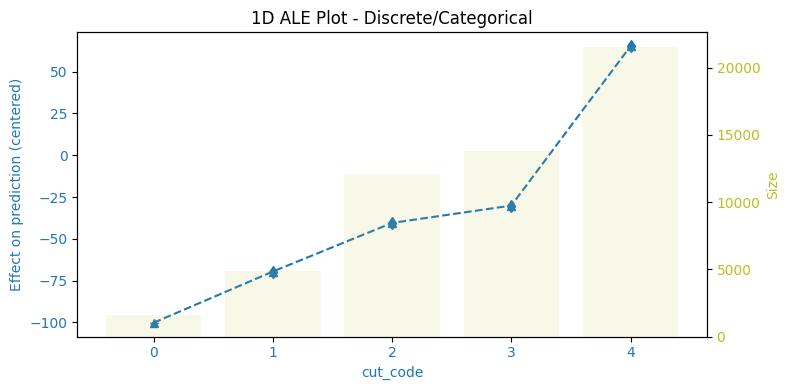

In [23]:
ALE_1D_IS.plot_1D_discrete_eff2(res_df_is.loc[:,["eff", "size", "lowerCI_95%", "upperCI_95%"]], X, fig=None, ax=None, verbose=True)